## Overview
This is an attempt at a model classification directly on the chest x-rays for TB

This notebook:
* reads the standard Montgomery and China X-ray files and other metadata such as diagnosis, demographics etc.
* compiles X-ray data with the labels and other details
* Out of memory processing by generating the batch on the fly
* Uses keras/tensorflow framework to model
* U-net model for image segmentation
* Augmentation is applied to generate many more training images
* Augmentated images are created and trained on the fly!


Notes:
1. Although we have lot more images (the augmented ones) the accuracy suffers a bit
2. However this should not be bad, the accuracy should be better on real images


Sources:
1. For unet: https://www.kaggle.com/nikhilpandey360/lung-segmentation-from-chest-x-ray-dataset

2. For genrator: https://www.kaggle.com/andrewmvd/workshop-tuberculosis-classification

* like to include is an image generator to generate more training images

### Import basic packages

In [13]:
!pip install matplotlib
!pip install scikit-image
!pip install seaborn
!pip install s3fs

You should consider upgrading via the '/usr/local/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.6 -m pip install --upgrade pip' command.
     |████████████████████████████████| 132 kB 20.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 76.6 MB/s eta 0:00:01
     |████████████████████████████████| 54 kB 492 kB/s  eta 0:00:01
     |████████████████████████████████| 8.1 MB 44.2 MB/s eta 0:00:01
     |████████████████████████████████| 191 kB 95.6 MB/s eta 0:00:01
     |████████████████████████████████| 159 kB 104.8 MB/s eta 0:00:01
     |████████████████████████████████| 270 kB 79.6 MB/s eta 0:00:01
  Created wheel for aiobotocore: filename=aiobotocore-2.0.1-py3-none-any.whl size=51993 sha256=f7d67e2db74f070637b01d9d13305e29be40e5401d655550d09041a00fe1bee8
  Stored in directory: /root/.cache/pip/wheels/7

In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
!pip install seaborn

You should consider upgrading via the '/usr/local/bin/python3.6 -m pip install --upgrade pip' command.


In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

import os
import glob
#from glob import glob 
import seaborn as sns
from skimage.util import montage
from skimage.io import imread


#from tqdm import tqdm
import cv2
from cv2 import imread, createCLAHE 


import s3fs # adding aws file management module

## Preprocessing the X-ray images: collecting various features including demographics and doctor's report

- read the relevant files
- clean them up
- compile them in to report dataframe

In [17]:
RUNNING_ON_AWS = True

In [18]:

base_dir = os.path.join('.', 'input', 'pulmonary-chest-xray-abnormalities\\')

base_dir

'./input/pulmonary-chest-xray-abnormalities\\'

In [19]:
    #get all the Montgomery set files
if RUNNING_ON_AWS == False:
    mont_dir = ".\\input\\Montgomery\\MontgomerySet\\"
    mont_paths = []
    for filename in glob.iglob(mont_dir + "**/*", recursive=False):
        mont_paths.append(filename)


IndentationError: expected an indented block (<ipython-input-19-34f81ce3cf0c>, line 3)

In [20]:
if RUNNING_ON_AWS == True:
    import s3fs
    fs = s3fs.S3FileSystem()
    montgomery_Files = fs.ls('s3://chexrayproject-allmontgomeryfiles')
    mont_paths = []
    #for filename in glob.iglob("montgomery_Files" + "**/*", recursive=False):
        #mont_paths.append(filename)
    for filename in montgomery_Files:
        mont_paths.append(filename)

In [22]:
#get all the China set files
if RUNNING_ON_AWS == False:
    shen_dir = ".\\input\\ChinaSet_AllFiles\\ChinaSet_AllFiles\\"
    shen_paths = []
    for filename in glob.iglob(shen_dir + "**/*", recursive=True):
         shen_paths.append(filename)

In [23]:
if RUNNING_ON_AWS == True:
    import s3fs
    fs = s3fs.S3FileSystem()
    china_Files = fs.ls('s3://chexrayproject-allchinafiles')
    shen_paths = []
    #for filename in glob.iglob("china_Files" + "**/*", recursive=False):
        #shen_paths.append(filename)
    for filename in china_Files:
        shen_paths.append(filename)

In [24]:
print('Montgomery Files', len(mont_paths))
print('Shenzhen Files', len(shen_paths))

Montgomery Files 277
Shenzhen Files 1325


#### Now combine al the files into a dataframe: all_paths_df

In [25]:
all_paths_df = pd.DataFrame(dict(path = mont_paths + shen_paths))
if RUNNING_ON_AWS == False:
    all_paths_df['source'] = all_paths_df['path'].map(lambda x: x.split('\\')[3])
else:
    all_paths_df['source'] = all_paths_df['path'].map(lambda x: x.split('/')[0].split('-')[1])
all_paths_df['file_id'] = all_paths_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
all_paths_df['patient_group']  = all_paths_df['file_id'].map(lambda x: x.split('_')[0])

all_paths_df['file_ext'] = all_paths_df['path'].map(lambda x: os.path.splitext(x)[1][1:])
all_paths_df = all_paths_df[all_paths_df.file_ext.isin(['png', 'txt'])]
all_paths_df['pulm_state']  = all_paths_df['file_id'].map(lambda x: int(x.split('_')[-1]))
all_paths_df.sample(5)

,path,source,file_id,patient_group,file_ext,pulm_state
306,chexrayproject-allchinafiles/CHNCXR_0015_0.txt,allchinafiles,CHNCXR_0015_0,CHNCXR,txt,0
481,chexrayproject-allchinafiles/CHNCXR_0103_0.png,allchinafiles,CHNCXR_0103_0,CHNCXR,png,0
507,chexrayproject-allchinafiles/CHNCXR_0116_0.png,allchinafiles,CHNCXR_0116_0,CHNCXR,png,0
708,chexrayproject-allchinafiles/CHNCXR_0216_0.txt,allchinafiles,CHNCXR_0216_0,CHNCXR,txt,0
1232,chexrayproject-allchinafiles/CHNCXR_0478_1.txt,allchinafiles,CHNCXR_0478_1,CHNCXR,txt,1


#### Now clean up the data and create the report_df

In [27]:
clean_patients_df = all_paths_df.pivot_table(index = ['patient_group', 'pulm_state', 'file_id'], 
                                             columns=['file_ext'], 
                                             values = 'path', aggfunc='first').reset_index()
clean_patients_df.sample(5)
from warnings import warn
def report_to_dict(in_path):
    with fs.open(in_path, 'r') as f:
        all_lines = [x.strip() for x in f.read().split('\n')]
    info_dict = {}
    try:
        if "Patient's Sex" in all_lines[0]:
            info_dict['age'] = all_lines[1].split(':')[-1].strip().replace('Y', '')
            info_dict['gender'] = all_lines[0].split(':')[-1].strip()
            info_dict['report'] = ' '.join(all_lines[2:]).strip()
        else:
            info_dict['age'] = all_lines[0].split(' ')[-1].replace('yrs', '').replace('yr', '')
            info_dict['gender'] = all_lines[0].split(' ')[0].strip()
            info_dict['report'] = ' '.join(all_lines[1:]).strip()
        
        info_dict['gender'] = info_dict['gender'].upper().replace('FEMALE', 'F').replace('MALE', 'M').replace('FEMAL', 'F')[0:1]
        if 'month' in info_dict.get('age', ''):
            info_dict.pop('age') # invalid
        if 'day' in info_dict.get('age', ''):
            info_dict.pop('age') # invalid
        elif len(info_dict.get('age',''))>0:
            info_dict['age'] = float(info_dict['age'])
        else:
            info_dict.pop('age')
        return info_dict
    except Exception as e:
        print(all_lines)
        warn(str(e), RuntimeWarning)
        return {}
if RUNNING_ON_AWS == False:    
    report_df = pd.DataFrame([dict(**report_to_dict(c_row.pop('txt')), **c_row) 
                  for  _, c_row in clean_patients_df.iterrows()])
else:
    report_df = pd.DataFrame([dict(**report_to_dict('s3://' + c_row.pop('txt')), **c_row) 
              for  _, c_row in clean_patients_df.iterrows()])
report_df.sample(5)

['male 16month', 'normal']


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: 'age'


['male 16month', 'normal']
['female24yrs', 'normal']


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: could not convert string to float: 'female24'


['male35yrs', 'PTB in the left upper field']
['male35yrs', 'Bilateral secondary PTB']


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: could not convert string to float: 'male35'


['Male , 38yrs,', 'secondary PTB in the bilateral upper and middle fields, mainly fibrous  lesions']


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: could not convert string to float: '38,'


,age,gender,report,patient_group,pulm_state,file_id,png
297,37.0,M,normal,CHNCXR,0,CHNCXR_0298_0,chexrayproject-allchinafiles/CHNCXR_0298_0.png
420,49.0,M,PTB in the right upper field,CHNCXR,1,CHNCXR_0421_1,chexrayproject-allchinafiles/CHNCXR_0421_1.png
226,50.0,M,normal,CHNCXR,0,CHNCXR_0227_0,chexrayproject-allchinafiles/CHNCXR_0227_0.png
394,31.0,M,"bilateral PTB, right pleurisy",CHNCXR,1,CHNCXR_0395_1,chexrayproject-allchinafiles/CHNCXR_0395_1.png
762,89.0,F,inactive scars RML. has completed treatment,MCUCXR,1,MCUCXR_0213_1,chexrayproject-allmontgomeryfiles/MCUCXR_0213_...


# Segmentation

In [9]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf

ModuleNotFoundError: No module named 'tqdm'

In [10]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

## Load the Xray and mask files

In [13]:
if RUNNING_ON_AWS == False

    #get all the mask files
    mask_path = os.path.join('D:\\Documents\\git\\med_imaging', "TB","Lung Segmentation","masks")

    #mask directory
    masks = os.listdir(mask_path)
    #clean it up to align with images names: Remove the .png and the _mask(from China masks)
    mask_ids_temp = [fName.split(".png")[0] for fName in masks]
    mask_ids = [fName.split("_mask")[0] for fName in mask_ids_temp]

    #The toal # of masks
    mask_file_names = [os.path.join(mask_path, mask) for mask in masks]

    #masks

    #Total number of modified maks - China maks
    check = [i for i in masks if "mask" in i]
    print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


In [ ]:
if RUNNING_ON_AWS == True:
    #get all the mask files
    #mask_path = os.path.join("D:\\", "Documents", "Medical", "TB","Lung Segmentation","masks")
    masks = fs.ls('s3://chexrayproject-masks')

    #mask_path = os.path.join('.', 'input', 'masks')

    #clean it up to align with images names: Remove the .png and the _mask(from China masks)


    mask_ids_temp = [fName.split(".png")[0] for fName in masks]

    mask_ids = [fName.split("_mask")[0] for fName in mask_ids_temp]

    #The total # of masks
    mask_file_names = [os.path.join('s3://chexrayproject-masks', mask) for mask in masks]

    #masks

    #Total number of modified masks - China masks
    check = [i for i in masks if "mask" in i]
    print("Total masks that have modified names:",len(check))

    ## ??? There seems to be 704 masks before modification



In [14]:
if RUNNING_ON_AWS == False:
    #get all the image files
    image_path = os.path.join('D:\\Documents\\git\\med_imaging', "TB","Lung Segmentation","CXR_png")

    #image directory
    images = os.listdir(image_path)

    #clean it up to align with images names: Remove the .png and the _mask(from China masks)
    image_ids = [fName.split(".png")[0] for fName in images]
    #mask_file_names = [fName.split("_mask")[0] for fName in mask_id]

    image_file_names = [os.path.join(image_path, image) for image in images]

    #The toal # of images
    print('Total X-ray images: ', len(image_file_names))


Total X-ray images:  800


In [ ]:
if RUNNING_ON_AWS == True:
    #get all the image files
    images = fs.ls('s3://chexrayproject-cxr-png')

    #image directory
    #images = os.listdir(image_path)

    #clean it up to align with images names: Remove the .png and the _mask(from China masks)
    image_ids = [fName.split(".png")[0] for fName in images]
    #mask_file_names = [fName.split("_mask")[0] for fName in mask_id]

    image_file_names = [os.path.join('s3://chexrayproject-cxr-png', image) for image in images]

    #The total # of images
    print('Total X-ray images: ', len(image_file_names))

In [15]:
#Put all the names into a dataframe for convenience
images_df = pd.DataFrame()
images_df['xrays'] = image_file_names
images_df['file_id'] = image_ids

images_with_masks_df = images_df[images_df['file_id'].isin(mask_ids)]

images_with_masks_df['masks'] = mask_file_names

print("There are {} x-rays with masks".format(len(images_with_masks_df)))

There are 704 x-rays with masks


C:\Users\gavir\AppData\Local\Temp/ipykernel_8460/2242941968.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  images_with_masks_df['masks'] = mask_file_names


In [16]:
from sklearn.model_selection import train_test_split
#Do a train-test split
train_x,test_x,train_y,test_y = train_test_split(images_with_masks_df['xrays'],
                                                   images_with_masks_df['masks'],test_size    = 0.1,
                                                   random_state = 42)

In [17]:
#Now set aside some of the training for validation
trainx,validationx,trainy,validationy = train_test_split(train_x,train_y,test_size = 0.1,random_state = 42)

In [18]:
#Put all these data sets into datframes
train_df = pd.DataFrame(index=trainx.index)
train_df['xrays'] = trainx
train_df['masks'] = trainy

test_df = pd.DataFrame(index=test_x.index)
test_df['xrays'] = test_x
test_df['masks'] = test_y

validation_df = pd.DataFrame(index=validationx.index)
validation_df['xrays'] = validationx
validation_df['masks'] = validationy

## Unet for segmentation

In [20]:
import tensorflow.keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [21]:
#https://www.kaggle.com/nikhilpandey360/lung-segmentation-from-chest-x-ray-dataset

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same')(inputs)
    #conv1 = Dropout(dropout)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same')(pool1)
    #conv2 = Dropout(dropout)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same')(pool2)
    #conv3 = Dropout(dropout)(conv3)
    conv3 = BatchNormalization()(conv3)    
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same')(pool3)
    #conv4 = Dropout(dropout)(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same')(pool4)
    #conv5 = Dropout(dropout)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    #up6 = Dropout(dropout)(up6)
    up6 = BatchNormalization()(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    #up7 = Dropout(dropout)(up7)
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    #up8 = Dropout(dropout)(up8)
    up7 = BatchNormalization()(up7)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    #up9 = Dropout(dropout)(up9)
    up9 = BatchNormalization()(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [22]:
#input_img = tf.keras.Input((1024, 1024, 1), name='img')
model = unet(input_size=(256,256,1))

#model = get_unet(input_img)
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        batch_normalization[0][0]        
_______________________________________________________________________________________

### The following generates a batch of augmented images and their masks on-the-fly for training!!

In [23]:
#These functions generate more images
dg_args = dict(featurewise_center = False, 
               samplewise_center = False,
               rescale = 1/255.,
               rotation_range = 5, 
               width_shift_range = 0.05, 
               height_shift_range = 0.05, 
               shear_range = 0.01,
               zoom_range = [0.8, 1.2],  
               # anatomically it doesnt make sense, but many images are flipped
               horizontal_flip = True,  
               vertical_flip = False,
               fill_mode = 'nearest',
               data_format = 'channels_last')



image_gen = ImageDataGenerator(**dg_args)

def gen_augmented_pairs(data_path_df, batch_size = 4):
    while True:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_img = image_gen.flow_from_dataframe(data_path_df, x_col='xrays', y_col= 'masks',
                                                    target_size=(512, 512), 
                                                    color_mode='grayscale', 
                                                    shuffle = False,
                                                    class_mode = None,
                                                    batch_size=8, seed=seed)
        
        g_masks = image_gen.flow_from_dataframe(data_path_df, x_col='masks', y_col= 'masks',
                                                    target_size=(512, 512), 
                                                    color_mode='grayscale', 
                                                    shuffle = False,
                                                    class_mode = None,
                                                    batch_size=8, seed=seed)
        
        for img, mask in zip(g_img,g_masks):
            yield img, mask


                    
train_gen = gen_augmented_pairs(train_df, batch_size = 8)
validation_gen = gen_augmented_pairs(validation_df, batch_size = 8)
test_gen = gen_augmented_pairs(test_df, batch_size = 8)
#print(train_X.shape, train_Y.shape)
#print(test_X.shape, test_Y.shape)

In [24]:
train_X, train_Y = next(train_gen)
test_X, test_Y = next(test_gen)

Found 569 validated image filenames.
Found 569 validated image filenames.
Found 71 validated image filenames.
Found 71 validated image filenames.


In [25]:
test_X.shape

(8, 512, 512, 1)

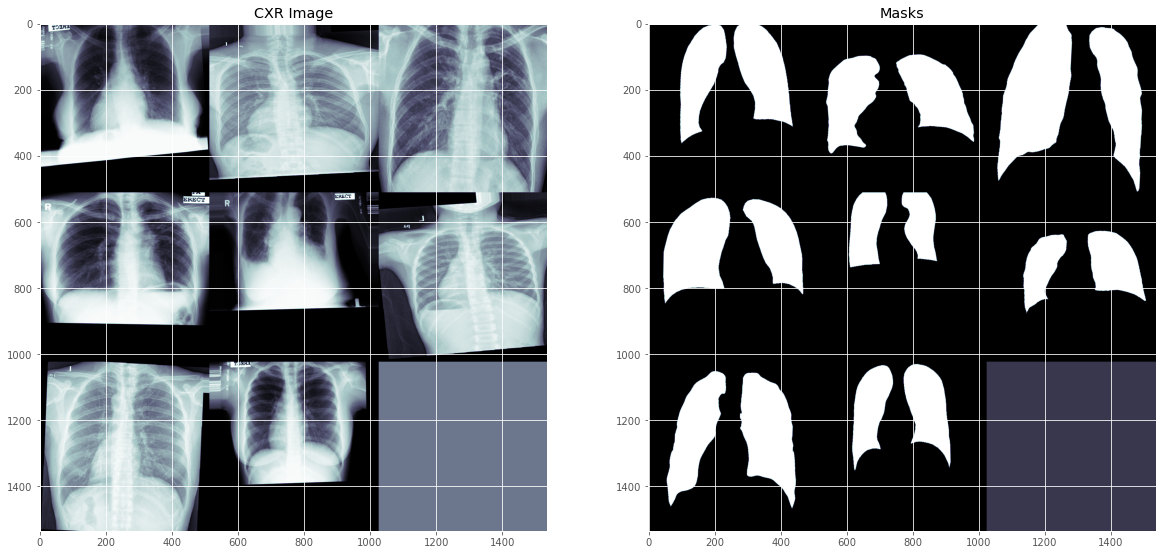

In [26]:
#Let us check it out to make sure the generated images syncs with masks
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage(train_X[:, :, :, 0]), cmap = 'bone')
ax1.set_title('CXR Image')
ax2.imshow(montage(train_Y[:, :, :, 0]), cmap = 'bone')
ax2.set_title('Masks')
plt.show()

## Callbacks

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, 
                                   verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6)

# probably needs to be more patient, but kaggle time is limited
#early = EarlyStopping(monitor="val_loss", mode="min",patience=15)
callbacks_list = [checkpoint, reduceLROnPlat]

## Training

In [37]:
from IPython.display import clear_output
from tensorflow.keras.optimizers import Adam 
from sklearn.model_selection import train_test_split


model = unet(input_size=(512, 512,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef, 'binary_accuracy'])

In [33]:
#Split the data set into training and validation
#train_vol, validation_vol, train_seg, validation_seg = train_test_split(X_scaled, y_scaled, test_size = 0.1,random_state = 42)

#Now set aside 10% of the train for testing
#train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, test_size = 0.1, random_state = 42)
#Instance of the generator
#train_seq = Xray_Sequence.flow_from_dataframe(train_df, test_x, im_size=1024, batch_size=2)
#validation_seq = Xray_Sequence.flow_from_dataframe(validation_df, test_x, im_size=1024, batch_size=2)
#loss_history = model.fit(x = train_vol,y = train_seg, batch_size = 8, epochs = 5, validation_data =(test_vol,test_seg), callbacks=callbacks_list)
results = model.fit_generator(train_gen,steps_per_epoch=500,epochs=10,
                              validation_data=validation_gen, validation_steps=50,
                              callbacks=callbacks_list)

#clear_output()

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
  2/500 [..............................] - ETA: 1:35:03 - loss: -0.3983 - dice_coef: 0.3983 - binary_accuracy: 0.4231

KeyboardInterrupt: 

In [31]:
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Dense, Conv2D

In [57]:
from tensorflow.keras.models import load_model
 
# load model
#model.save('mask_segmentation_unet_augmented_4_3_20_model.h5')
model = load_model('mask_segmentation_unet_augmented_4_5_20_model_alt.h5',
                   custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})

TypeError: 'NoneType' object is not subscriptable

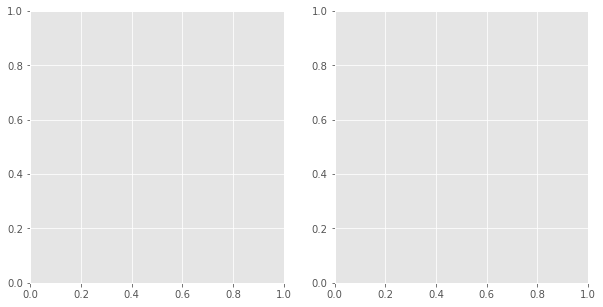

In [58]:
#https://www.kaggle.com/nikhilpandey360/lung-segmentation-from-chest-x-ray-dataset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(results.history['loss'], '-', label = 'Loss')
ax1.plot(results.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(results.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(results.history['val_binary_accuracy']), '-',label = 'Validation Accuracy')
ax2.legend()

### Now let us collect some the test images, their masks, and predicted masks

In [61]:
#Now generate a few images for testing

test_X, test_Y = next(test_gen)

preds = model.predict(test_X)

In [62]:
test_Y[1].shape

(512, 512, 1)

In [63]:
preds.shape

(8, 512, 512, 1)

In [64]:
test_X.shape

(8, 512, 512, 1)

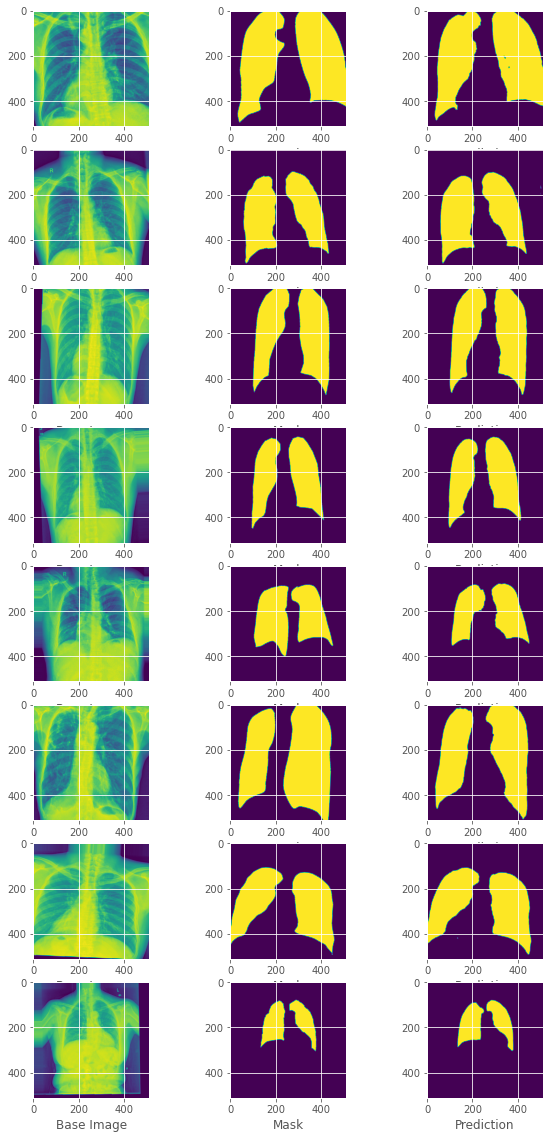

In [65]:
plt.figure(figsize=(10,20))

for i in range(0,8):
    plt.subplot(8,3,3*i+1)
    plt.imshow(np.squeeze(test_X[i]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(8,3,3*i+2)
    plt.imshow(np.squeeze(test_Y[i]))
    plt.xlabel("Mask")
    
    plt.subplot(8,3,3*i+3)
    plt.imshow(np.squeeze(preds[i]))
    plt.xlabel("Prediction")

### Now let us take a look at some images elsewhere

In [66]:
##New images
test_img_path = os.path.join('D:\\Documents\\git\\med_imaging', "X_rays","images_01\\") #stanford data set, doesn't come with masks.
test_files = os.listdir(test_img_path)
#test_x = os.path.join(test_img_path,test_files[i])

In [67]:
#Put it into a series format for conformance to the sequencing script:(
test_x = [os.path.join(test_img_path,file) for file in test_files]
test_x = pd.DataFrame(test_x, columns=['xrays'])
test_x['masks'] = ''

In [68]:
test_gen = gen_augmented_pairs(test_x, batch_size = 8)

In [69]:
#Create a mask predictions with the U-net model
test_X, test_Y = next(test_gen)

Found 4999 validated image filenames.
Found 0 validated image filenames.


C:\Users\gavir\.conda\envs\geo\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 4999 invalid image filename(s) in x_col="masks". These filename(s) will be ignored.
  warnings.warn(


In [70]:
test_X.shape

(8, 512, 512, 1)

In [71]:
#pred_candidates = np.random.randint(0,3,3)
preds = model.predict(test_X)

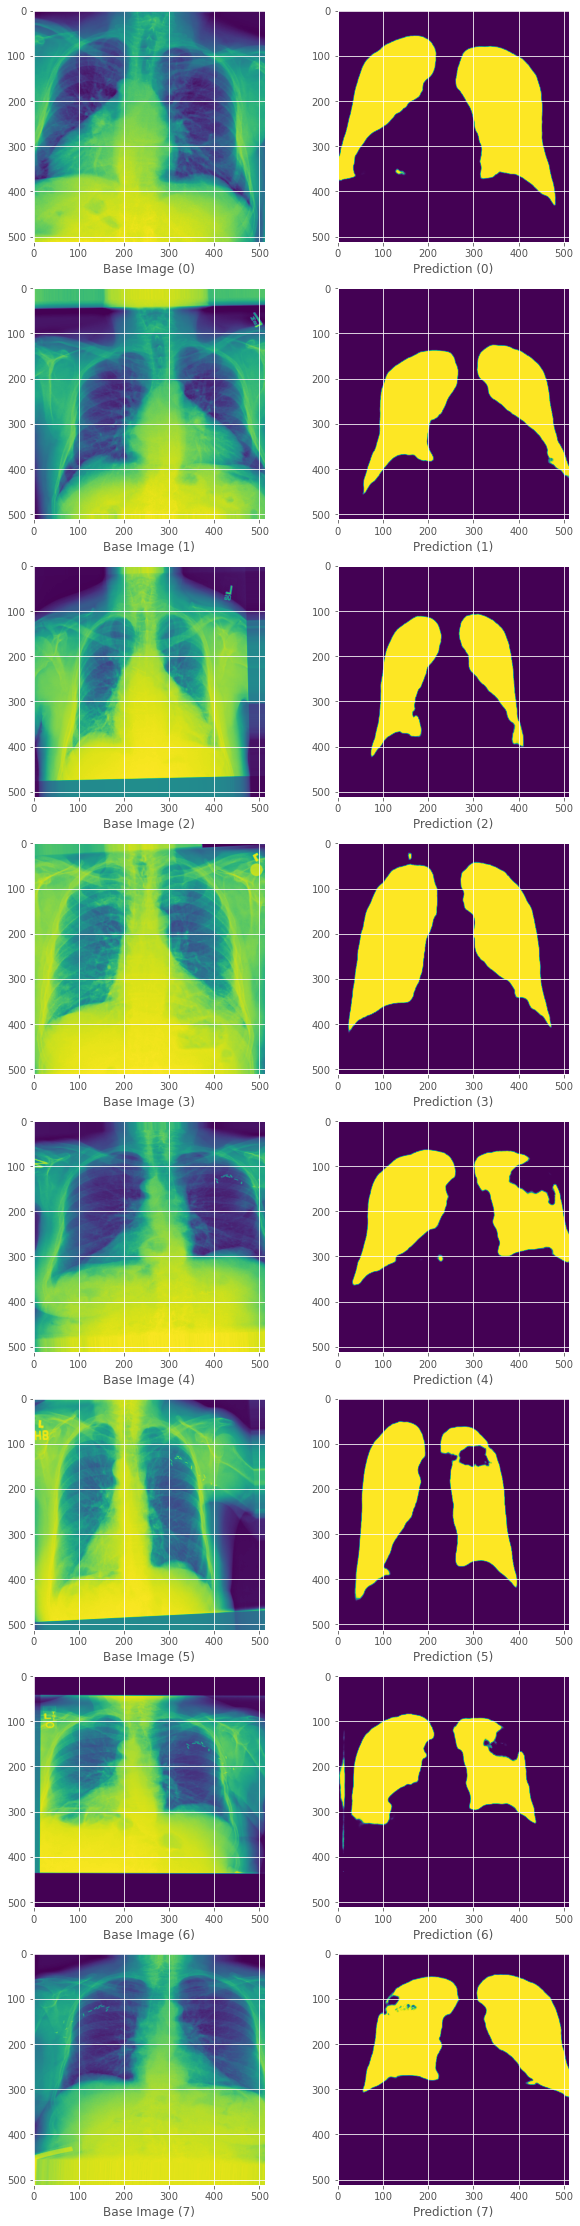

In [72]:
#Now plot the images versus mask predictions

plt.figure(figsize=(10,40))

for i in range(8):
    plt.subplot(8,2,2*i+1)
    plt.imshow(np.squeeze(test_X[i]))
    plt.xlabel("Base Image (" + str(i) + ")")
    
    
    plt.subplot(8,2,2*i+2)
    plt.imshow(np.squeeze(preds[i]))
    plt.xlabel("Prediction (" + str(i) + ")")